In [1]:
from astropy.table import Table, Column, table, vstack, setdiff
from pathlib import Path

import numpy as np

from matplotlib import pyplot as plt

In [2]:
path_raw='../Datos/Raw/'
path_phot_ned = '../Datos/Work/Phot_Tables_NED/' #In this path wi will save the photometry tables for each object
path_phot_cds = '../Datos/Work/Phot_Tables_CDS/'
path_SED = '../Datos/Work/SEDs/'
path_CIGALE_phot = '../Datos/Work/CIGALE_InputPhot/'
path_CIGALE_out = '../Datos/Work/CIGALE_Output/'
path_FINAL = '../Datos/Final/'

groups = ['Group_01/','Group_02/','Group_03/','Group_04/','Group_05/',\
          'Group_06/','Group_07/','Group_08/','Group_09/','Group_10/']
out = ['out_1/','out_2/']

Read and join all the results of CIGALE of each group: out_1 (parameter i between 0° and 40°) and out 2 (parameter i between 0° and 40°) 

In [3]:
output_1 = Table()
output_2 = Table()

for i in range(10):
    CIGPhotIn = Table()
    out_1 = Table()
    out_2 = Table()
    CIGPhotIn = Table.read(path_CIGALE_phot+'CIGPhot_EnergyBal_'+str(i+1)+'.tbl', format='ascii')
    out_1 = Table.read(path_CIGALE_out+groups[i]+out[0]+'results.fits',format='fits')
    out_2 = Table.read(path_CIGALE_out+groups[i]+out[1]+'results.fits',format='fits')
    
    out_1 = out_1[np.concatenate([np.where(out_1['id'] == oid)[0] for oid in CIGPhotIn['id']])]
    out_2 = out_2[np.concatenate([np.where(out_2['id'] == oid)[0] for oid in CIGPhotIn['id']])]
    
    output_1 = vstack([out_1, output_1]) #Join all the result tables from CIGALE
    output_2 = vstack([out_2, output_2]) #Join all the result tables from CIGALE
    
output_1['log.reduced_chi_square'] = np.log10(output_1['best.reduced_chi_square'])
output_2['log.reduced_chi_square'] = np.log10(output_2['best.reduced_chi_square'])

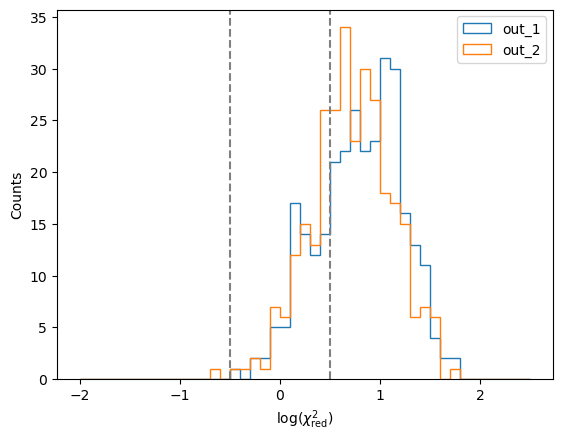

In [22]:
binsChiS = np.linspace(-2.0, 2.5, 46)  # Assuming Chisquare bins in this ranges
plt.hist(output_1['log.reduced_chi_square'], bins=binsChiS, histtype='step', label='out_1')
plt.hist(output_2['log.reduced_chi_square'], bins=binsChiS, histtype='step', label='out_2')
plt.axvline(x=-0.5,ls='--',color='gray')
plt.axvline(x=0.5,ls='--',color='gray')
plt.xlabel(r'$\log(\chi^2_{\rm{red}})$')
plt.ylabel('Counts')
plt.legend()

Re-order the two tables by id according the general table from the input data of CIGALE (Notebook 4):

In [4]:
Phot = Table.read(path_FINAL+'CIGPhot_EnergyBal_All.tbl', format='ascii')
Nbands = [sum(~np.isnan(list(row)[2::2])) for row in Phot]
output_1 = output_1[np.concatenate([np.where(output_1['id'] == oid)[0] for oid in Phot['id']])]
output_2 = output_2[np.concatenate([np.where(output_2['id'] == oid)[0] for oid in Phot['id']])]

To select for each galaxy what results we are going to use from the two groups of results from CIGALE, we use the Bayesian inference criterion (BIC) defined as $\rm{BIC}= \chi^2 + k\times\ln(N)$, where k is the number of parameters and N are the number of data points (bands), and is an approximation of the Bayes factor ([Buat et. al 2019](https://ui.adsabs.harvard.edu/abs/2019A%26A...632A..79B/abstract), [Salmon et al. 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...827...20S/abstract)). Then, we can calculate the $\Delta\rm{BIC}$ to compare the out_1 and the out_2 models.

In [5]:
output_1['DBIC'] = output_1['best.chi_square'] - output_2['best.chi_square']
output_2['DBIC'] = output_2['best.chi_square'] - output_1['best.chi_square']

In [6]:
out_1_clean = output_1[np.logical_and.reduce([output_1['best.reduced_chi_square'] <= 10**0.5, \
                                            output_1['best.reduced_chi_square'] >= 10**-0.5,\
                                            output_1['DBIC'] < 2])]

out_2_clean = output_2[np.logical_and.reduce([output_2['best.reduced_chi_square'] <= 10**0.5, \
                                            output_2['best.reduced_chi_square'] >= 10**-0.5, \
                                            output_2['DBIC'] < 2])]

Number of galaxies removed after the cleaining

In [7]:
removed_galaxies_1 = len(output_1)-len(out_1_clean)
removed_galaxies_2 = len(output_2)-len(out_2_clean)
print('The number of galaxies removed in out_1 are:',removed_galaxies_1)
print('The number of galaxies removed in out_2 are:',removed_galaxies_2)

The number of galaxies removed in out_1 are: 249
The number of galaxies removed in out_2 are: 225


In [8]:
Cond1 = sum(np.logical_or(output_1['best.reduced_chi_square'] >= 10**0.5, \
                          output_1['best.reduced_chi_square'] <= 10**-0.5))/removed_galaxies_1
Cond2 = sum(output_1['DBIC'] >= 2)/removed_galaxies_1

In [9]:
Cond1

0.8955823293172691

Now we are going to detect which galaxies are still in both out_1 and out_2 tables. This happends because in both cases the $\Delta\rm{BIC}$ was < 2 in each table

In [10]:
sdiff_1 = setdiff(out_1_clean, out_2_clean, keys=['id']) #galaxies that are in out_1_clean but not in out_2_clean
galx_in_1_2 = setdiff(out_1_clean, sdiff_1, keys=['id']) #galaxies that are in out_1_clean but not in sdiff_1

sdiff_2 = setdiff(out_2_clean, out_1_clean, keys=['id']) #galaxies that are in out_2_clean but not in out_1_clean
galx_in_2_1 = setdiff(out_2_clean, sdiff_2, keys=['id']) #galaxies that are in out_2_clean but not in sdiff_2

**"galx_in_1_2" and "galx_in_2_1" must to have the same galaxies!**. These are the galaxies that are in out_1 and out_2 after the first cleaning

In [11]:
galx_in_1_2['id','bayes.agn.i','DBIC','bayes.agn.fracAGN','bayes.agn.fracAGN_err','best.reduced_chi_square']

id,bayes.agn.i,DBIC,bayes.agn.fracAGN,bayes.agn.fracAGN_err,best.reduced_chi_square
,deg,,,,
bytes26,float64,float64,float64,float64,float64
2C 1883,24.145652952403985,-1.5401167015662907,0.10049235409817402,0.00493775070050137,1.9118542546292236
2MASS J22255427+1958370,17.30436684575215,-0.9748554714976212,0.7777985012141335,0.09277788847973355,0.744351440526346
ESO 140-43,12.42403790243719,1.88619402248899,0.8529978808513041,0.013182541267928337,1.3844477863369917
ESO 417-6,17.87974945993726,-1.317077173823634,0.5719352979589454,0.04384712016492106,2.819210212564002
IRAS 15091-2107,25.065946231868967,-1.1026812031322066,0.7128427256191021,0.02352157993599299,2.108589926952913
LEDA 3095998,21.529501614709947,1.6780849124682682,0.10017517860705573,0.0031922557898241173,0.8092576162341433
Mrk 79,7.710626649808848,1.5079555862292295,0.7975752530894813,0.010897403595890415,1.9537383233964216
Mrk 883,21.558078064235723,0.21647484704758924,0.10650956905026687,0.016863246393831337,0.5428952970188512


In [12]:
galx_in_2_1['id','bayes.agn.i','DBIC','bayes.agn.fracAGN','bayes.agn.fracAGN_err','best.reduced_chi_square']

id,bayes.agn.i,DBIC,bayes.agn.fracAGN,bayes.agn.fracAGN_err,best.reduced_chi_square
,deg,,,,
bytes26,float64,float64,float64,float64,float64
2C 1883,50.81842491206819,1.5401167015662907,0.11332112775238543,0.025141415005005174,1.9974162936051287
2MASS J22255427+1958370,50.924762838794464,0.9748554714976212,0.7228003618225171,0.12175474626127512,0.8329746652079479
ESO 140-43,50.00008010856014,-1.88619402248899,0.8216338937981892,0.054923700647671166,1.285174416732308
ESO 417-6,50.74673269571298,1.317077173823634,0.5273427845037293,0.07035692978591923,2.901527535927979
IRAS 15091-2107,50.00000147430416,1.1026812031322066,0.7179321129210998,0.030020063162792182,2.156532587958661
LEDA 3095998,77.09923799429123,-1.6780849124682682,0.13870063473849112,0.09075242622477846,0.6973852887362587
Mrk 79,50.743067647129024,-1.5079555862292295,0.6962286955418483,0.0481889206349962,1.8978881164990427
Mrk 883,68.08109459872324,-0.21647484704758924,0.1622780983563833,0.04889716370003436,0.5293656190783769


In [13]:
to_rem_o1 = [out_1_clean.remove_rows(np.where(out_1_clean['id'] == i)[0]) for i in galx_in_1_2['id']]
to_rem_o2 = [out_2_clean.remove_rows(np.where(out_2_clean['id'] == i)[0]) for i in galx_in_2_1['id']]

In [14]:
results = vstack([out_1_clean, out_2_clean])
results = results[np.concatenate([np.where(results['id'] == oid)[0] for oid in Phot['id']])]
results.write(path_CIGALE_out+'results_All.fits', format='fits',overwrite=True)
results.write(path_CIGALE_out+'results_All.txt', format='ascii',overwrite=True)
results['id','bayes.agn.fracAGN','bayes.agn.fracAGN_err','bayes.agn.i','bayes.agn.i_err','best.reduced_chi_square']

id,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,best.reduced_chi_square
,,,deg,deg,
bytes26,float64,float64,float64,float64,float64
3C 234.0,0.6152849893143326,0.06297197598042098,68.68651792673369,3.3778824115135047,1.571543266404707
2MASS J13000535+1632148,0.899273174709466,0.005985980504553072,60.00034211182109,0.058489411166235517,2.8333819812086842
LEDA 45656,0.8472202932086663,0.01151398898386999,33.63494915560232,7.94023216707574,2.2454603529280117
Mrk 1239,0.8365647091501113,0.02432237125246894,50.000000000000014,2.569164998981261e-07,1.8967714733159189
LEDA 89032,0.6957030429683679,0.10199481397442349,17.99686557526552,13.315502066396546,2.0966484839026136
LEDA 89511,0.8460700406566882,0.021547623019378785,60.000563585316,0.07507020402380189,1.9016316971799583
Mrk 493,0.49129190376927084,0.03327493391686072,50.04689018034157,0.7134460032683382,1.2886078561494567
LEDA 90196,0.18766213124853867,0.063784338572934,73.63566761611061,6.942441234748504,1.7454627080454634
